In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [4]:
# Load the dataset
df = pd.read_csv('lyrics_lens_sample_dataset.csv')

# Display basic information
print("Dataset Shape:", df.shape)
print("\nFirst Few Rows:")
print(df.head())

print("\nColumn Names and Types:")
print(df.dtypes)

print("\nBasic Statistics:")
print(df.describe())

print("\nMissing Values:")
print(df.isnull().sum())

print("\nUnique Emotions:")
print(df['emotion_label'].value_counts())

Dataset Shape: (20, 13)

First Few Rows:
                  artist              song_title genre  year  \
0           Taylor Swift            Shake It Off   Pop  2015   
1      Pharrell Williams                   Happy   Pop  2013   
2  Katrina and the Waves     Walking on Sunshine   Pop  1985   
3                   ABBA           Dancing Queen   Pop  1976   
4      Justin Timberlake  Can't Stop the Feeling   Pop  2016   

                                      lyrics_snippet  valence  arousal  \
0  I stay out too late, got nothing in my brain, ...     0.85     0.75   
1  Clap along if you feel like a room without a r...     0.92     0.82   
2     I'm walking on sunshine and don't it feel good     0.90     0.80   
3  You can dance, you can jive, having the time o...     0.88     0.78   
4  I got that sunshine in my pocket, got that goo...     0.87     0.85   

   negativity emotion_label  energy  danceability  acousticness  tempo  
0        0.10         Happy    0.83          0.84       

In [5]:
# Map audio features to personality dimensions
# Based on psychology: Big Five Personality Model + Emotional Dimensions

FEATURE_MAPPING = {
    'Openness': ['danceability', 'energy', 'valence'],  # Openness = diverse, energetic, positive
    'Conscientiousness': ['acousticness', 'tempo'],  # Conscientiousness = organized, moderate tempo
    'Extraversion': ['energy', 'danceability', 'valence'],  # Extraversion = energetic, social, positive
    'Agreeableness': ['acousticness', 'valence'],  # Agreeableness = warm, positive
    'Neuroticism': ['negativity', 'arousal'],  # Neuroticism = anxious, emotional
}

# Define emotion categories for classification
EMOTION_WEIGHTS = {
    'Happy': {'Extraversion': 0.9, 'Openness': 0.85, 'Agreeableness': 0.8, 'Conscientiousness': 0.6, 'Neuroticism': 0.1},
    'Sad': {'Neuroticism': 0.85, 'Openness': 0.5, 'Extraversion': 0.2, 'Agreeableness': 0.6, 'Conscientiousness': 0.4},
    'Angry': {'Neuroticism': 0.9, 'Extraversion': 0.7, 'Openness': 0.6, 'Conscientiousness': 0.3, 'Agreeableness': 0.1},
    'Relaxed': {'Agreeableness': 0.8, 'Conscientiousness': 0.75, 'Neuroticism': 0.1, 'Extraversion': 0.4, 'Openness': 0.6},
}

print("Feature Mapping to Personality Dimensions:")
for personality, features in FEATURE_MAPPING.items():
    print(f"{personality}: {features}")

Feature Mapping to Personality Dimensions:
Openness: ['danceability', 'energy', 'valence']
Conscientiousness: ['acousticness', 'tempo']
Extraversion: ['energy', 'danceability', 'valence']
Agreeableness: ['acousticness', 'valence']
Neuroticism: ['negativity', 'arousal']


In [6]:
def calculate_song_personality_profile(row):
    """
    Calculate personality profile for a single song based on audio features.
    Returns a dictionary with Big Five personality scores (0-1 scale).
    """
    personality_scores = {}

    # Normalize features to 0-1 scale if not already
    features_dict = {
        'valence': row.valence,
        'arousal': row.arousal,
        'negativity': row.negativity,
        'energy': row.energy,
        'danceability': row.danceability,
        'acousticness': row.acousticness,
        'tempo': row.tempo / 200,  # Normalize tempo (0-200 BPM)
    }

    # Openness: High for diverse, energetic, positive music
    openness = (features_dict['danceability'] * 0.4 +
                features_dict['energy'] * 0.35 +
                features_dict['valence'] * 0.25)
    personality_scores['Openness'] = min(openness, 1.0)

    # Conscientiousness: Higher for structured, acoustic, moderate tempo
    conscientiousness = (features_dict['acousticness'] * 0.5 +
                        (1 - abs(features_dict['tempo'] - 0.5)) * 0.3 +  # Moderate tempo preferred
                        (1 - features_dict['energy']) * 0.2)
    personality_scores['Conscientiousness'] = min(conscientiousness, 1.0)

    # Extraversion: High for energetic, danceable, positive
    extraversion = (features_dict['energy'] * 0.4 +
                   features_dict['danceability'] * 0.35 +
                   features_dict['valence'] * 0.25)
    personality_scores['Extraversion'] = min(extraversion, 1.0)

    # Agreeableness: High for positive, acoustic, low negativity
    agreeableness = (features_dict['valence'] * 0.4 +
                    features_dict['acousticness'] * 0.3 +
                    (1 - features_dict['negativity']) * 0.3)
    personality_scores['Agreeableness'] = min(agreeableness, 1.0)

    # Neuroticism: High for negative, high arousal, angry/sad
    neuroticism = (features_dict['negativity'] * 0.4 +
                  features_dict['arousal'] * 0.3 +
                  (1 - features_dict['valence']) * 0.3)
    personality_scores['Neuroticism'] = min(neuroticism, 1.0)

    return personality_scores

# Calculate personality profiles for all songs
df['personality_profile'] = df.apply(calculate_song_personality_profile, axis=1)

# Extract individual personality dimensions
for personality in ['Openness', 'Conscientiousness', 'Extraversion', 'Agreeableness', 'Neuroticism']:
    df[personality] = df['personality_profile'].apply(lambda x: x[personality])

print("Sample Personality Profiles (First 5 Songs):")
print(df[['artist', 'song_title', 'emotion_label', 'Openness', 'Conscientiousness',
          'Extraversion', 'Agreeableness', 'Neuroticism']].head())

Sample Personality Profiles (First 5 Songs):
                  artist              song_title emotion_label  Openness  \
0           Taylor Swift            Shake It Off         Happy    0.8390   
1      Pharrell Williams                   Happy         Happy    0.8025   
2  Katrina and the Waves     Walking on Sunshine         Happy    0.7710   
3                   ABBA           Dancing Queen         Happy    0.7390   
4      Justin Timberlake  Can't Stop the Feeling         Happy    0.8710   

   Conscientiousness  Extraversion  Agreeableness  Neuroticism  
0            0.42930        0.8385          0.703        0.310  
1            0.36380        0.7975          0.686        0.290  
2            0.38635        0.7740          0.687        0.302  
3            0.39645        0.7435          0.673        0.318  
4            0.33465        0.8690          0.657        0.330  


Average Personality Traits by Emotion:
               Openness  Conscientiousness  Extraversion  Agreeableness  \
emotion_label                                                             
Angry            0.4570            0.42120        0.4750         0.1702   
Happy            0.8045            0.38211        0.8045         0.6812   
Relaxed          0.4227            0.74152        0.4188         0.6390   
Sad              0.2875            0.71801        0.2880         0.3374   

               Neuroticism  
emotion_label               
Angry               0.8620  
Happy               0.3100  
Relaxed             0.3230  
Sad                 0.6386  


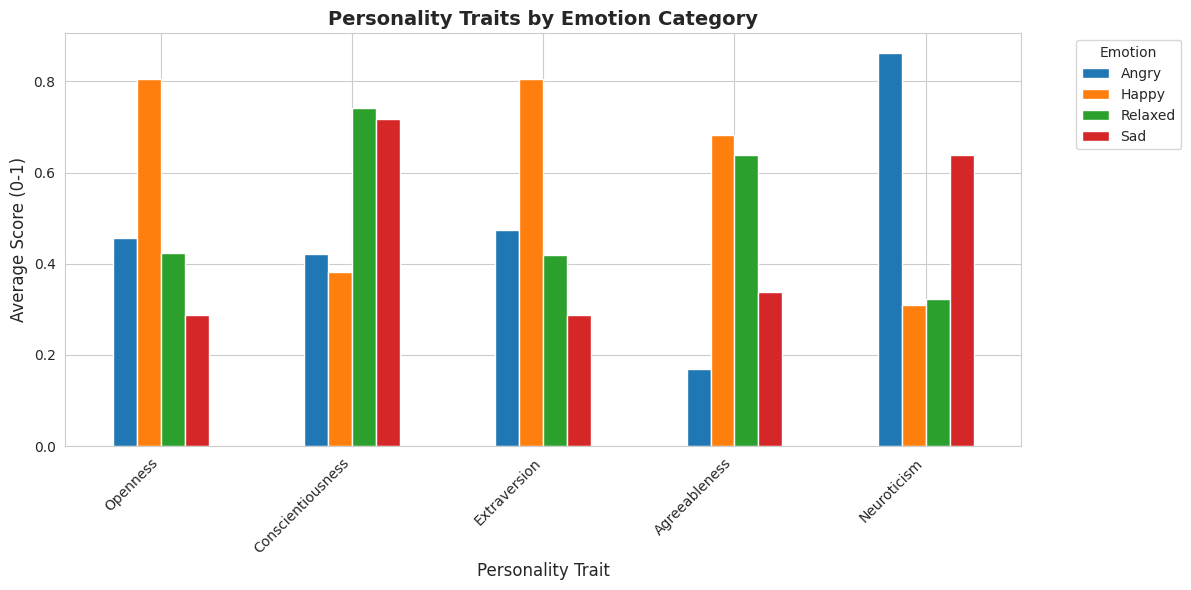

In [7]:
# Group by emotion and calculate average personality
personality_by_emotion = df.groupby('emotion_label')[
    ['Openness', 'Conscientiousness', 'Extraversion', 'Agreeableness', 'Neuroticism']
].mean()

print("Average Personality Traits by Emotion:")
print(personality_by_emotion)

# Visualize personality profiles by emotion
fig, ax = plt.subplots(figsize=(12, 6))
personality_by_emotion.T.plot(kind='bar', ax=ax)
plt.title('Personality Traits by Emotion Category', fontsize=14, fontweight='bold')
plt.xlabel('Personality Trait', fontsize=12)
plt.ylabel('Average Score (0-1)', fontsize=12)
plt.legend(title='Emotion', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Average Personality Traits by Genre:
             Openness  Conscientiousness  Extraversion  Agreeableness  \
genre                                                                   
Alternative     0.223              0.716         0.223          0.329   
Hip-Hop         0.430              0.392         0.447          0.180   
Industrial      0.475              0.503         0.488          0.182   
Jazz            0.386              0.771         0.386          0.597   
Metal           0.442              0.429         0.468          0.191   
Pop             0.593              0.538         0.591          0.577   
R&B             0.302              0.641         0.314          0.318   
Reggae          0.464              0.795         0.463          0.763   
Rock            0.449              0.556         0.456          0.346   

             Neuroticism  
genre                     
Alternative        0.627  
Hip-Hop            0.822  
Industrial         0.904  
Jazz               0.36

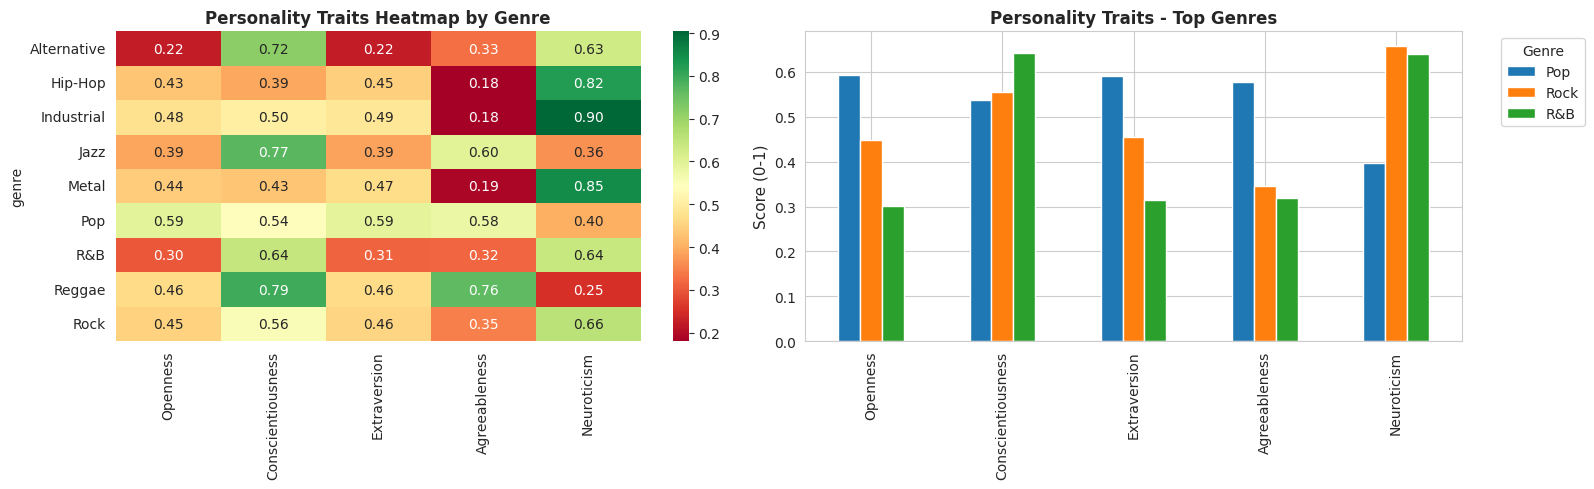

In [8]:
# Group by genre and calculate average personality
personality_by_genre = df.groupby('genre')[
    ['Openness', 'Conscientiousness', 'Extraversion', 'Agreeableness', 'Neuroticism']
].mean()

print("\nAverage Personality Traits by Genre:")
print(personality_by_genre.round(3))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Heatmap
sns.heatmap(personality_by_genre, annot=True, fmt='.2f', cmap='RdYlGn', ax=axes[0])
axes[0].set_title('Personality Traits Heatmap by Genre', fontsize=12, fontweight='bold')

# Bar plot for top 3 genres
top_genres = df['genre'].value_counts().head(3).index
personality_by_genre.loc[top_genres].T.plot(kind='bar', ax=axes[1])
axes[1].set_title('Personality Traits - Top Genres', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Score (0-1)', fontsize=11)
axes[1].legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [9]:
# Prepare data for clustering
personality_features = ['Openness', 'Conscientiousness', 'Extraversion', 'Agreeableness', 'Neuroticism']
X = df[personality_features].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-means clustering (4 clusters = 4 personality archetypes)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df['personality_cluster'] = kmeans.fit_predict(X_scaled)

# Define cluster names (personality archetypes)
archetype_names = {
    0: 'Adventurous Explorer',
    1: 'Calm Harmonizer',
    2: 'Intense Rebel',
    3: 'Creative Dreamer'
}

df['personality_archetype'] = df['personality_cluster'].map(archetype_names)

print("Songs Clustered by Personality Archetype:")
print(df['personality_archetype'].value_counts())

# Analyze cluster characteristics
print("\n\nCluster Centers (Original Scale):")
cluster_centers = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=personality_features
)
cluster_centers.index = [archetype_names[i] for i in range(4)]
print(cluster_centers.round(3))

Songs Clustered by Personality Archetype:
personality_archetype
Adventurous Explorer    6
Calm Harmonizer         5
Intense Rebel           5
Creative Dreamer        4
Name: count, dtype: int64


Cluster Centers (Original Scale):
                      Openness  Conscientiousness  Extraversion  \
Adventurous Explorer     0.293              0.724         0.292   
Calm Harmonizer          0.804              0.382         0.804   
Intense Rebel            0.457              0.421         0.475   
Creative Dreamer         0.449              0.739         0.446   

                      Agreeableness  Neuroticism  
Adventurous Explorer          0.366        0.605  
Calm Harmonizer               0.681        0.310  
Intense Rebel                 0.170        0.862  
Creative Dreamer              0.671        0.294  


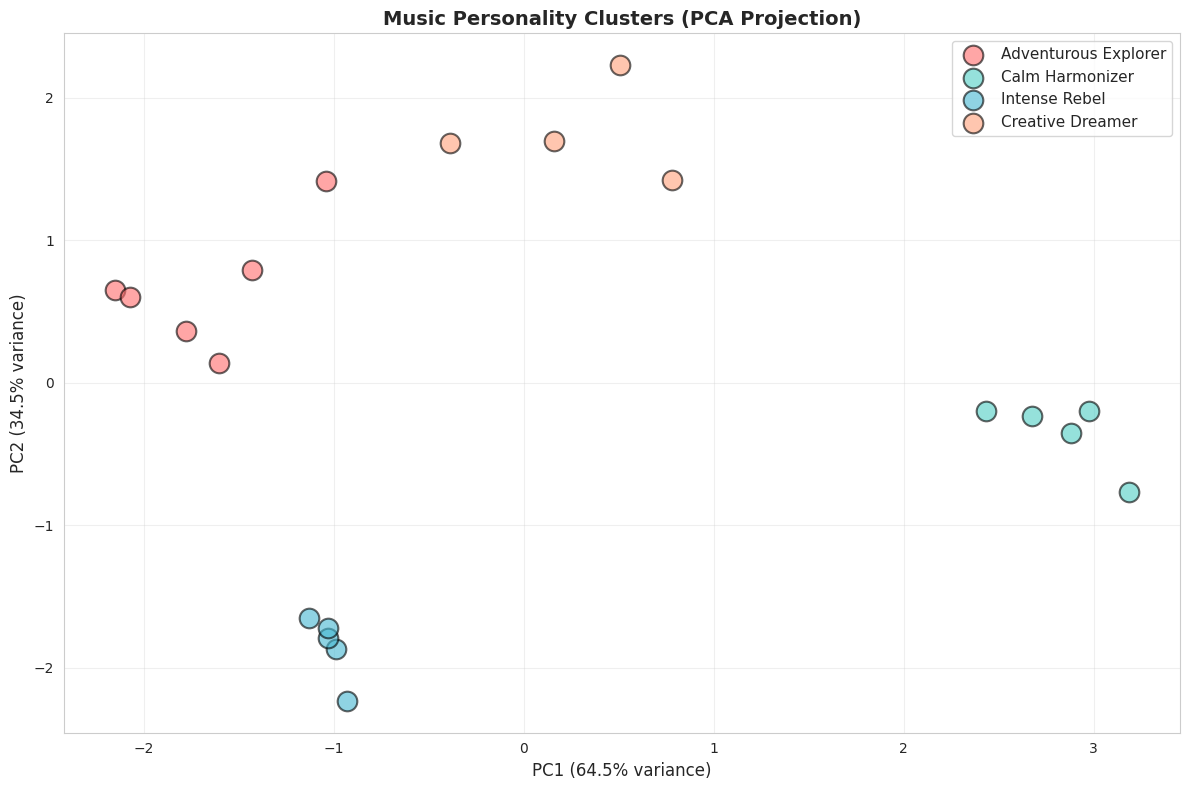


Total Variance Explained by 2 PCs: 99.0%


In [10]:
# Apply PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create scatter plot
fig, ax = plt.subplots(figsize=(12, 8))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

for i, archetype in enumerate(archetype_names.values()):
    mask = df['personality_cluster'] == i
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1],
              c=colors[i], label=archetype, s=200, alpha=0.6, edgecolors='black', linewidth=1.5)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
ax.set_title('Music Personality Clusters (PCA Projection)', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nTotal Variance Explained by 2 PCs: {pca.explained_variance_ratio_.sum():.1%}")

In [11]:
def generate_song_report(song_row):
    """
    Generate a detailed personality profile report for a single song.
    """
    report = {
        'Artist': song_row['artist'],
        'Song Title': song_row['song_title'],
        'Genre': song_row['genre'],
        'Year': song_row['year'],
        'Dominant Emotion': song_row['emotion_label'],
        'Personality Archetype': song_row['personality_archetype'],
        'Openness': f"{song_row['Openness']:.2f}",
        'Conscientiousness': f"{song_row['Conscientiousness']:.2f}",
        'Extraversion': f"{song_row['Extraversion']:.2f}",
        'Agreeableness': f"{song_row['Agreeableness']:.2f}",
        'Neuroticism': f"{song_row['Neuroticism']:.2f}",
        'Energy Level': 'High' if song_row['energy'] > 0.6 else 'Moderate' if song_row['energy'] > 0.3 else 'Low',
        'Danceability': 'High' if song_row['danceability'] > 0.6 else 'Moderate' if song_row['danceability'] > 0.3 else 'Low',
        'Acoustic': 'Yes' if song_row['acousticness'] > 0.5 else 'No',
        'Tempo (BPM)': f"{song_row['tempo']:.1f}",
    }
    return report

# Display sample reports
print("="*80)
print("SAMPLE SONG PERSONALITY PROFILES")
print("="*80)

for idx in range(min(3, len(df))):
    report = generate_song_report(df.iloc[idx])
    print(f"\n{'─'*80}")
    for key, value in report.items():
        print(f"{key:.<30} {value}")

SAMPLE SONG PERSONALITY PROFILES

────────────────────────────────────────────────────────────────────────────────
Artist........................ Taylor Swift
Song Title.................... Shake It Off
Genre......................... Pop
Year.......................... 2015
Dominant Emotion.............. Happy
Personality Archetype......... Calm Harmonizer
Openness...................... 0.84
Conscientiousness............. 0.43
Extraversion.................. 0.84
Agreeableness................. 0.70
Neuroticism................... 0.31
Energy Level.................. High
Danceability.................. High
Acoustic...................... No
Tempo (BPM)................... 139.8

────────────────────────────────────────────────────────────────────────────────
Artist........................ Pharrell Williams
Song Title.................... Happy
Genre......................... Pop
Year.......................... 2013
Dominant Emotion.............. Happy
Personality Archetype......... Calm Harmoni

In [12]:
def profile_songs_list(song_list):
    """
    Create a music personality profile for a list of songs.

    Parameters:
    -----------
    song_list : list of tuples
        Each tuple contains: (artist, song_title, audio_features_dict)
        audio_features_dict should have keys: valence, arousal, negativity, energy,
                                              danceability, acousticness, tempo

    Returns:
    --------
    dict : Aggregate personality profile for the playlist
    """

    if not song_list:
        return None

    personality_scores = {
        'Openness': [],
        'Conscientiousness': [],
        'Extraversion': [],
        'Agreeableness': [],
        'Neuroticism': []
    }

    songs_data = []

    # Process each song
    for item in song_list:
        if len(item) == 3:
            artist, title, features = item
        else:
            print(f"Warning: Invalid song entry format. Skipping: {item}")
            continue

        # Create a row-like object from features
        class SongRow:
            def __init__(self, feat_dict):
                for key, val in feat_dict.items():
                    setattr(self, key, val)

        row = SongRow(features)
        profile = calculate_song_personality_profile(row)

        for personality, score in profile.items():
            personality_scores[personality].append(score)

        songs_data.append({
            'artist': artist,
            'title': title,
            **profile # Include individual song profiles
        })

    # Calculate aggregate profile
    aggregate_profile = {
        personality: np.mean(scores) for personality, scores in personality_scores.items()
    }

    # Determine dominant archetype (using aggregate profile)
    # Note: This is a simplified approach. A more robust method would involve
    # projecting the aggregate profile onto the PCA space and finding the closest cluster center.
    # For this example, we'll find the cluster center closest in Euclidean distance in the original space.
    archetype_idx = np.argmin([
        np.linalg.norm([aggregate_profile[p] - cluster_centers.loc[archetype_names[i], p]
                        for p in personality_features])
        for i in range(4)
    ])


    return {
        'personality_profile': aggregate_profile,
        'songs': songs_data, # Return songs with individual profiles
        'archetype': archetype_names[archetype_idx],
        # Removed 'average_scores'
    }

print("Function 'profile_songs_list' created successfully!")

Function 'profile_songs_list' created successfully!


In [13]:
# Example: Create a custom playlist and profile it
# Format: (Artist, Song Title, Audio Features Dictionary)

custom_playlist = [
    ('Taylor Swift', 'Shake It Off',
     {'valence': 0.85, 'arousal': 0.75, 'negativity': 0.1, 'energy': 0.83,
      'danceability': 0.84, 'acousticness': 0.31, 'tempo': 139.8}),

    ('Pharrell Williams', 'Happy',
     {'valence': 0.92, 'arousal': 0.82, 'negativity': 0.05, 'energy': 0.71,
      'danceability': 0.81, 'acousticness': 0.11, 'tempo': 132.8}),

    ('Coldplay', 'Fix You',
     {'valence': 0.22, 'arousal': 0.4, 'negativity': 0.68, 'energy': 0.33,
      'danceability': 0.45, 'acousticness': 0.75, 'tempo': 79.5}),

    ('Bob Marley', 'Three Little Birds',
     {'valence': 0.7, 'arousal': 0.3, 'negativity': 0.18, 'energy': 0.38,
      'danceability': 0.39, 'acousticness': 0.79, 'tempo': 83.8}),
]

# Profile the playlist
playlist_profile = profile_songs_list(custom_playlist)

print("="*80)
print("CUSTOM PLAYLIST PERSONALITY PROFILE")
print("="*80)

print(f"\nPlaylist Size: {len(playlist_profile['songs'])} songs")
print(f"\nSongs in Playlist:")
for i, song in enumerate(playlist_profile['songs'], 1):
    print(f"  {i}. {song['artist']} - {song['title']}")

print(f"\n{'─'*80}")
print("AGGREGATE PERSONALITY PROFILE")
print(f"{'─'*80}")
print(f"\nPrimary Archetype: {playlist_profile['archetype']}")

print(f"\nPersonality Trait Scores (0-1 scale):")
for trait, score in playlist_profile['personality_profile'].items():
    bar_length = int(score * 30)
    bar = '█' * bar_length + '░' * (30 - bar_length)
    print(f"  {trait:.<25} {bar} {score:.3f}")

CUSTOM PLAYLIST PERSONALITY PROFILE

Playlist Size: 4 songs

Songs in Playlist:
  1. Taylor Swift - Shake It Off
  2. Pharrell Williams - Happy
  3. Coldplay - Fix You
  4. Bob Marley - Three Little Birds

────────────────────────────────────────────────────────────────────────────────
AGGREGATE PERSONALITY PROFILE
────────────────────────────────────────────────────────────────────────────────

Primary Archetype: Creative Dreamer

Personality Trait Scores (0-1 scale):
  Openness................. ██████████████████░░░░░░░░░░░░ 0.614
  Conscientiousness........ █████████████████░░░░░░░░░░░░░ 0.592
  Extraversion............. ██████████████████░░░░░░░░░░░░ 0.611
  Agreeableness............ ███████████████████░░░░░░░░░░░ 0.640
  Neuroticism.............. ███████████░░░░░░░░░░░░░░░░░░░ 0.369


In [14]:
def interpret_personality_profile(profile_dict):
    """
    Generate human-readable interpretation of a personality profile.
    """
    profile = profile_dict['personality_profile']
    archetype = profile_dict['archetype']

    interpretation = {
        'archetype': archetype,
        'traits': {}
    }

    traits_interpretation = {
        'Openness': {
            'high': 'Enjoys exploring diverse musical styles and experimental sounds',
            'low': 'Prefers familiar, conventional music styles'
        },
        'Conscientiousness': {
            'high': 'Appreciates structured, organized compositions; likes instrumental elements',
            'low': 'Drawn to energetic, less predictable musical arrangements'
        },
        'Extraversion': {
            'high': 'Loves upbeat, danceable music with high energy',
            'low': 'Prefers calmer, more introspective musical experiences'
        },
        'Agreeableness': {
            'high': 'Drawn to positive, harmonious music; empathetic to lyrics',
            'low': 'May prefer intense, challenging musical content'
        },
        'Neuroticism': {
            'high': 'Engages with emotionally intense, passionate music',
            'low': 'Prefers emotionally stable, relaxing musical content'
        }
    }

    for trait, score in profile.items():
        if score > 0.6:
            level = 'high'
        elif score < 0.4:
            level = 'low'
        else:
            level = 'moderate'

        interpretation['traits'][trait] = {
            'score': score,
            'level': level,
            'description': traits_interpretation[trait][level] if level in ['high', 'low'] else 'Balanced preference'
        }

    return interpretation

# Generate interpretation
interpretation = interpret_personality_profile(playlist_profile)

print("\n" + "="*80)
print("PERSONALITY INTERPRETATION & INSIGHTS")
print("="*80)

print(f"\nArchetype: {interpretation['archetype']}")
print(f"\n{'─'*80}")
print("Trait Interpretations:")
print(f"{'─'*80}\n")

for trait, info in interpretation['traits'].items():
    print(f"{trait} ({info['level'].upper()}: {info['score']:.2f})")
    print(f"  └─ {info['description']}\n")


PERSONALITY INTERPRETATION & INSIGHTS

Archetype: Creative Dreamer

────────────────────────────────────────────────────────────────────────────────
Trait Interpretations:
────────────────────────────────────────────────────────────────────────────────

Openness (HIGH: 0.61)
  └─ Enjoys exploring diverse musical styles and experimental sounds

Conscientiousness (MODERATE: 0.59)
  └─ Balanced preference

Extraversion (HIGH: 0.61)
  └─ Loves upbeat, danceable music with high energy

Agreeableness (HIGH: 0.64)
  └─ Drawn to positive, harmonious music; empathetic to lyrics

Neuroticism (LOW: 0.37)
  └─ Prefers emotionally stable, relaxing musical content



PLAYLIST COMPARISON: Happy vs. Melancholic

Trait                Happy Playlist       Melancholic Playlist Difference     
───────────────────────────────────────────────────────────────────────────
Openness             0.821                0.299                0.521          
Conscientiousness    0.397                0.673                -0.277         
Extraversion         0.818                0.308                0.510          
Agreeableness        0.695                0.315                0.380          
Neuroticism          0.300                0.642                -0.342         


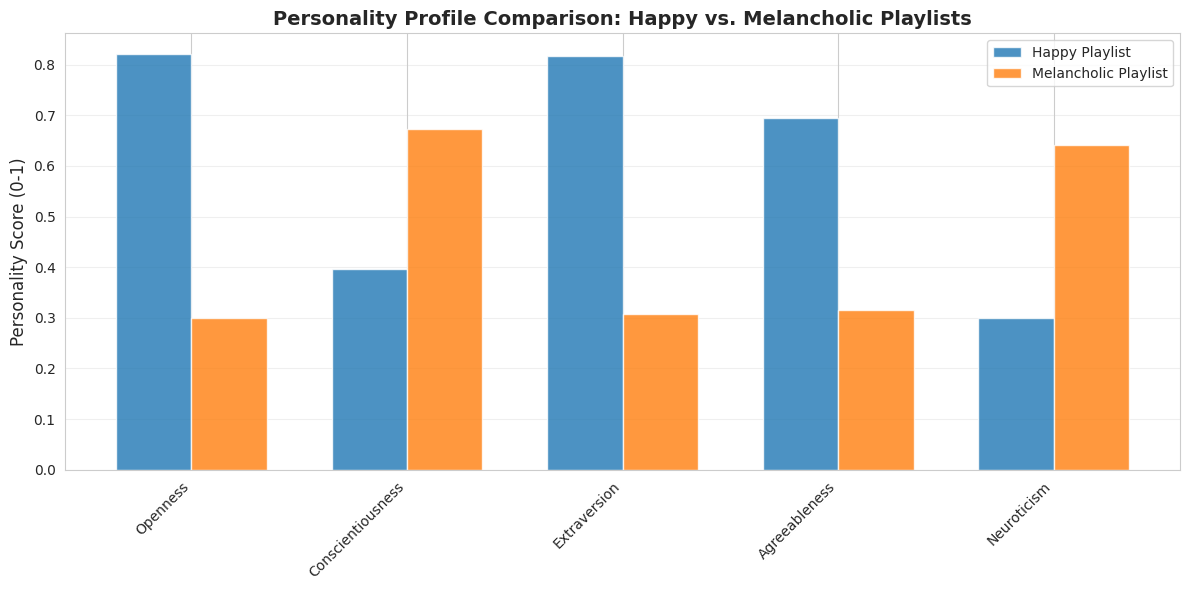

In [15]:
# Example: Compare two different playlists

happy_playlist = [
    ('Taylor Swift', 'Shake It Off',
     {'valence': 0.85, 'arousal': 0.75, 'negativity': 0.1, 'energy': 0.83,
      'danceability': 0.84, 'acousticness': 0.31, 'tempo': 139.8}),
    ('Pharrell Williams', 'Happy',
     {'valence': 0.92, 'arousal': 0.82, 'negativity': 0.05, 'energy': 0.71,
      'danceability': 0.81, 'acousticness': 0.11, 'tempo': 132.8}),
]

melancholic_playlist = [
    ('Adele', 'Someone Like You',
     {'valence': 0.15, 'arousal': 0.3, 'negativity': 0.75, 'energy': 0.4,
      'danceability': 0.3, 'acousticness': 0.59, 'tempo': 93.3}),
    ('Sam Smith', 'Stay With Me',
     {'valence': 0.18, 'arousal': 0.35, 'negativity': 0.72, 'energy': 0.47,
      'danceability': 0.23, 'acousticness': 0.54, 'tempo': 76.9}),
]

# Profile both
profile_happy = profile_songs_list(happy_playlist)
profile_melancholic = profile_songs_list(melancholic_playlist)

# Compare
print("="*80)
print("PLAYLIST COMPARISON: Happy vs. Melancholic")
print("="*80)

traits = list(profile_happy['personality_profile'].keys())

print(f"\n{'Trait':<20} {'Happy Playlist':<20} {'Melancholic Playlist':<20} {'Difference':<15}")
print("─" * 75)

for trait in traits:
    happy_score = profile_happy['personality_profile'][trait]
    melancholic_score = profile_melancholic['personality_profile'][trait]
    diff = happy_score - melancholic_score

    print(f"{trait:<20} {happy_score:<20.3f} {melancholic_score:<20.3f} {diff:<15.3f}")

# Visualize comparison
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(traits))
width = 0.35

happy_scores = [profile_happy['personality_profile'][t] for t in traits]
melancholic_scores = [profile_melancholic['personality_profile'][t] for t in traits]

ax.bar(x - width/2, happy_scores, width, label='Happy Playlist', alpha=0.8)
ax.bar(x + width/2, melancholic_scores, width, label='Melancholic Playlist', alpha=0.8)

ax.set_ylabel('Personality Score (0-1)', fontsize=12)
ax.set_title('Personality Profile Comparison: Happy vs. Melancholic Playlists', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(traits, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

In [16]:
# Export comprehensive analysis
export_df = df[[
    'artist', 'song_title', 'genre', 'year', 'emotion_label',
    'Openness', 'Conscientiousness', 'Extraversion', 'Agreeableness', 'Neuroticism',
    'personality_archetype', 'energy', 'danceability', 'acousticness', 'tempo'
]].copy()

export_df = export_df.round(3)

# Save to CSV
export_df.to_csv('music_personality_profiles.csv', index=False)

print("Analysis exported to 'music_personality_profiles.csv'")
print(f"\nExport Preview (first 10 rows):")
print(export_df.head(10))

print(f"\n\nSummary Statistics:")
print(export_df[[
    'Openness', 'Conscientiousness', 'Extraversion', 'Agreeableness', 'Neuroticism'
]].describe().round(3))

Analysis exported to 'music_personality_profiles.csv'

Export Preview (first 10 rows):
                  artist              song_title        genre  year  \
0           Taylor Swift            Shake It Off          Pop  2015   
1      Pharrell Williams                   Happy          Pop  2013   
2  Katrina and the Waves     Walking on Sunshine          Pop  1985   
3                   ABBA           Dancing Queen          Pop  1976   
4      Justin Timberlake  Can't Stop the Feeling          Pop  2016   
5                  Adele        Someone Like You          Pop  2011   
6              Sam Smith            Stay With Me          R&B  2014   
7          Billie Eilish   When The Party's Over  Alternative  2018   
8               Coldplay                 Fix You         Rock  2005   
9          Lewis Capaldi       Someone You Loved          Pop  2018   

  emotion_label  Openness  Conscientiousness  Extraversion  Agreeableness  \
0         Happy     0.839              0.429         0

In [17]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
import numpy as np

def create_personality_dashboard(profile_dict, playlist_name="My Playlist"):
    """
    Create a comprehensive dashboard visualizing personality profile results.

    Parameters:
    -----------
    profile_dict : dict
        Output from profile_songs_list() function
    playlist_name : str
        Name of the playlist for the dashboard title
    """

    fig = plt.figure(figsize=(18, 12))
    gs = GridSpec(3, 3, figure=fig, hspace=0.35, wspace=0.3)

    profile = profile_dict['personality_profile']
    archetype = profile_dict['archetype']
    songs = profile_dict['songs']

    # Color scheme
    color_palette = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#95E1D3']
    trait_colors = {
        'Openness': '#FF6B6B',
        'Conscientiousness': '#4ECDC4',
        'Extraversion': '#45B7D1',
        'Agreeableness': '#FFA07A',
        'Neuroticism': '#95E1D3'
    }

    traits = list(profile.keys())
    scores = list(profile.values())

    # ===== 1. Title and Archetype (Top Center) =====
    ax_title = fig.add_subplot(gs[0, :])
    ax_title.axis('off')

    archetype_emoji = {
        'Adventurous Explorer': '🚀',
        'Calm Harmonizer': '🕊️',
        'Intense Rebel': '⚡',
        'Creative Dreamer': '🎨'
    }

    emoji = archetype_emoji.get(archetype, '🎵')
    ax_title.text(0.5, 0.7, f"{emoji} {playlist_name}",
                  ha='center', va='center', fontsize=24, fontweight='bold')
    ax_title.text(0.5, 0.3, f"Personality Archetype: {archetype}",
                  ha='center', va='center', fontsize=18, color='#333333')
    ax_title.set_xlim(0, 1)
    ax_title.set_ylim(0, 1)

    # ===== 2. Radar Chart (Left) =====
    ax_radar = fig.add_subplot(gs[1, 0], projection='polar')

    angles = np.linspace(0, 2*np.pi, len(traits), endpoint=False).tolist()
    # Fix: Append only the first score to close the loop for the radar chart
    scores_plot = scores + [scores[0]]
    angles += angles[:1]

    ax_radar.plot(angles, scores_plot, 'o-', linewidth=2.5, color='#FF6B6B', markersize=8)
    ax_radar.fill(angles, scores_plot, alpha=0.25, color='#FF6B6B')
    ax_radar.set_xticks(angles[:-1])
    ax_radar.set_xticklabels(traits, size=10)
    ax_radar.set_ylim(0, 1)
    ax_radar.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax_radar.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], size=8)
    ax_radar.grid(True, linestyle='--', alpha=0.7)
    ax_radar.set_title('Personality Profile (Radar)', fontsize=12, fontweight='bold', pad=20)

    # ===== 3. Horizontal Bar Chart (Center) =====
    ax_bar = fig.add_subplot(gs[1, 1:])

    y_pos = np.arange(len(traits))
    colors_list = [trait_colors[trait] for trait in traits]

    bars = ax_bar.barh(y_pos, scores, color=colors_list, alpha=0.8, edgecolor='black', linewidth=1.5)
    ax_bar.set_yticks(y_pos)
    ax_bar.set_yticklabels(traits, fontsize=11)
    ax_bar.set_xlabel('Score (0-1)', fontsize=11, fontweight='bold')
    ax_bar.set_title('Personality Trait Scores', fontsize=12, fontweight='bold')
    ax_bar.set_xlim(0, 1)

    # Add value labels on bars
    for i, (bar, score) in enumerate(zip(bars, scores)):
        ax_bar.text(score + 0.02, i, f'{score:.2f}', va='center', fontsize=10, fontweight='bold')

    ax_bar.grid(True, alpha=0.3, axis='x')

    # ===== 4. Trait Descriptions (Bottom Left) =====
    ax_desc = fig.add_subplot(gs[2, 0])
    ax_desc.axis('off')

    descriptions = []
    for trait, score in zip(traits, scores):
        if score > 0.6:
            level = 'HIGH'
            emoji = '📈'
        elif score < 0.4:
            level = 'LOW'
            emoji = '📉'
        else:
            level = 'MED'
            emoji = '➡️'
        descriptions.append(f"{emoji} {trait}: {level}")

    desc_text = "\n".join(descriptions)
    ax_desc.text(0.05, 0.95, "Trait Levels:", fontsize=11, fontweight='bold',
                 va='top', transform=ax_desc.transAxes)
    ax_desc.text(0.05, 0.80, desc_text, fontsize=10, va='top',
                 transform=ax_desc.transAxes, family='monospace',
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

    # ===== 5. Songs in Playlist (Bottom Center) =====
    ax_songs = fig.add_subplot(gs[2, 1:])
    ax_songs.axis('off')

    song_text = f"Songs in Playlist ({len(songs)}):\n\n"
    for i, song in enumerate(songs, 1):
        song_text += f"{i}. {song['artist']} - {song['title']}\n"

    ax_songs.text(0.05, 0.95, song_text, fontsize=10, va='top',
                  transform=ax_songs.transAxes, family='monospace',
                  bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

    plt.suptitle(f"Music Personality Profiling Dashboard",
                 fontsize=20, fontweight='bold', y=0.98)

    plt.tight_layout()
    plt.show()

    return fig

# Example usage:
# create_personality_dashboard(playlist_profile, "My Favorite Playlist")

In [18]:
def create_interactive_frontend_app():
    """
    Create an interactive HTML/CSS/JavaScript frontend for music personality profiling.
    This generates a complete web application that can be saved and opened in a browser.
    """

    html_content = """
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Music Personality Profiler</title>
        <script src="https://cdnjs.cloudflare.com/ajax/libs/Chart.js/3.9.1/chart.min.js"></script>
        <style>
            * {
                margin: 0;
                padding: 0;
                box-sizing: border-box;
            }

            body {
                font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
                background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
                min-height: 100vh;
                padding: 20px;
            }

            .container {
                max-width: 1400px;
                margin: 0 auto;
            }

            header {
                text-align: center;
                color: white;
                margin-bottom: 30px;
            }

            header h1 {
                font-size: 2.5em;
                margin-bottom: 10px;
                text-shadow: 2px 2px 4px rgba(0,0,0,0.3);
            }

            header p {
                font-size: 1.1em;
                opacity: 0.9;
            }

            .main-content {
                display: grid;
                grid-template-columns: 1fr 1fr;
                gap: 20px;
                margin-bottom: 30px;
            }

            .card {
                background: white;
                border-radius: 12px;
                padding: 25px;
                box-shadow: 0 8px 32px rgba(0,0,0,0.1);
                backdrop-filter: blur(4px);
            }

            .card h2 {
                color: #667eea;
                margin-bottom: 20px;
                font-size: 1.5em;
                border-bottom: 2px solid #667eea;
                padding-bottom: 10px;
            }

            .form-group {
                margin-bottom: 20px;
            }

            label {
                display: block;
                margin-bottom: 8px;
                color: #333;
                font-weight: 600;
            }

            input[type="text"],
            input[type="number"],
            textarea {
                width: 100%;
                padding: 12px;
                border: 2px solid #e0e0e0;
                border-radius: 8px;
                font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
                transition: border-color 0.3s;
            }

            input[type="text"]:focus,
            input[type="number"]:focus,
            textarea:focus {
                outline: none;
                border-color: #667eea;
                box-shadow: 0 0 0 3px rgba(102, 126, 234, 0.1);
            }

            textarea {
                resize: vertical;
                min-height: 100px;
                font-size: 0.95em;
            }

            .song-input-group {
                background: #f8f9ff;
                padding: 15px;
                border-radius: 8px;
                margin-bottom: 15px;
                border-left: 4px solid #667eea;
            }

            .song-input-group input {
                margin-bottom: 10px;
            }

            .song-input-group input:last-child {
                margin-bottom: 0;
            }

            button {
                background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
                color: white;
                padding: 14px 28px;
                border: none;
                border-radius: 8px;
                font-size: 1em;
                font-weight: 600;
                cursor: pointer;
                transition: transform 0.2s, box-shadow 0.2s;
                width: 100%;
            }

            button:hover {
                transform: translateY(-2px);
                box-shadow: 0 8px 16px rgba(102, 126, 234, 0.4);
            }

            button:active {
                transform: translateY(0);
            }

            .button-group {
                display: grid;
                grid-template-columns: 1fr 1fr;
                gap: 10px;
            }

            .btn-secondary {
                background: #6c757d;
            }

            .btn-secondary:hover {
                box-shadow: 0 8px 16px rgba(108, 117, 125, 0.4);
            }

            .results-section {
                grid-column: 1 / -1;
                display: none;
            }

            .results-section.active {
                display: block;
            }

            .archetype-box {
                background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
                color: white;
                padding: 25px;
                border-radius: 12px;
                text-align: center;
                margin-bottom: 20px;
                grid-column: 1 / -1;
            }

            .archetype-box h3 {
                font-size: 2em;
                margin-bottom: 10px;
            }

            .archetype-box p {
                font-size: 1.1em;
                opacity: 0.95;
            }

            .emoji {
                font-size: 2.5em;
                margin-bottom: 10px;
            }

            .chart-container {
                position: relative;
                height: 300px;
                margin-bottom: 20px;
            }

            .trait-grid {
                display: grid;
                grid-template-columns: repeat(auto-fit, minmax(200px, 1fr));
                gap: 15px;
                margin-bottom: 20px;
            }

            .trait-card {
                background: #f8f9ff;
                padding: 20px;
                border-radius: 8px;
                border-left: 4px solid;
                text-align: center;
                transition: transform 0.2s;
            }

            .trait-card:hover {
                transform: translateY(-5px);
            }

            .trait-card.openness { border-color: #FF6B6B; }
            .trait-card.conscientiousness { border-color: #4ECDC4; }
            .trait-card.extraversion { border-color: #45B7D1; }
            .trait-card.agreeableness { border-color: #FFA07A; }
            .trait-card.neuroticism { border-color: #95E1D3; }

            .trait-name {
                font-weight: 600;
                color: #333;
                margin-bottom: 8px;
            }

            .trait-score {
                font-size: 1.8em;
                font-weight: bold;
                color: #667eea;
                margin-bottom: 8px;
            }

            .trait-level {
                font-size: 0.9em;
                color: #666;
            }

            .progress-bar {
                width: 100%;
                height: 8px;
                background: #e0e0e0;
                border-radius: 4px;
                overflow: hidden;
                margin-top: 10px;
            }

            .progress-fill {
                height: 100%;
                background: linear-gradient(90deg, #667eea, #764ba2);
                transition: width 0.3s;
            }

            .songs-list {
                background: #f8f9ff;
                padding: 15px;
                border-radius: 8px;
                margin-bottom: 20px;
            }

            .songs-list h4 {
                color: #667eea;
                margin-bottom: 12px;
            }

            .song-item {
                padding: 10px;
                background: white;
                border-radius: 6px;
                margin-bottom: 8px;
                border-left: 3px solid #667eea;
                padding-left: 12px;
            }

            .song-artist {
                font-weight: 600;
                color: #333;
            }

            .song-title {
                color: #666;
                font-size: 0.95em;
            }

            .loading {
                display: none;
                text-align: center;
                padding: 20px;
            }

            .loading.active {
                display: block;
            }

            .spinner {
                border: 4px solid #f3f3f3;
                border-top: 4px solid #667eea;
                border-radius: 50%;
                width: 40px;
                height: 40px;
                animation: spin 1s linear infinite;
                margin: 0 auto 15px;
            }

            @keyframes spin {
                0% { transform: rotate(0deg); }
                100% { transform: rotate(360deg); }
            }

            .error-message {
                background: #ffebee;
                color: #c62828;
                padding: 15px;
                border-radius: 8px;
                margin-bottom: 20px;
                border-left: 4px solid #c62828;
                display: none;
            }

            .error-message.active {
                display: block;
            }

            .success-message {
                background: #e8f5e9;
                color: #2e7d32;
                padding: 15px;
                border-radius: 8px;
                margin-bottom: 20px;
                border-left: 4px solid #2e7d32;
                display: none;
            }

            .success-message.active {
                display: block;
            }

            @media (max-width: 1024px) {
                .main-content {
                    grid-template-columns: 1fr;
                }
            }

            .input-mode-toggle {
                display: grid;
                grid-template-columns: 1fr 1fr;
                gap: 10px;
                margin-bottom: 20px;
            }

            .mode-btn {
                padding: 10px;
                border: 2px solid #e0e0e0;
                background: white;
                border-radius: 8px;
                cursor: pointer;
                font-weight: 600;
                color: #666;
                transition: all 0.3s;
            }

            .mode-btn.active {
                background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
                color: white;
                border-color: #667eea;
            }

            .sample-data {
                background: #fff3cd;
                padding: 15px;
                border-radius: 8px;
                margin-bottom: 15px;
                border-left: 4px solid #ffc107;
            }

            .sample-data p {
                margin-bottom: 10px;
                font-size: 0.95em;
            }

            .sample-code {
                background: #f8f9fa;
                padding: 10px;
                border-radius: 4px;
                font-family: monospace;
                font-size: 0.85em;
                overflow-x: auto;
                color: #333;
            }
        </style>
    </head>
    <body>
        <div class="container">
            <header>
                <h1>🎵 Music Personality Profiler</h1>
                <p>Discover your music personality through AI-powered analysis</p>
            </header>

            <div class="main-content">
                <!-- Input Section -->
                <div class="card">
                    <h2>Input Your Playlist</h2>

                    <div class="input-mode-toggle">
                        <button class="mode-btn active" data-mode="form">Add Songs</button>
                        <button class="mode-btn" data-mode="json">JSON Import</button>
                    </div>

                    <!-- Form Mode -->
                    <div id="formMode" class="input-mode">
                        <div id="songsContainer"></div>

                        <button class="btn-secondary" id="addSongBtn" style="margin-bottom: 15px;">+ Add Another Song</button>

                        <div class="sample-data">
                            <p><strong>Sample Song Format:</strong></p>
                            <div class="sample-code">Artist: Taylor Swift<br>
Song: Shake It Off<br>
Valence: 0.85 | Energy: 0.83<br>
Danceability: 0.84 | Tempo: 139.8</div>
                        </div>
                    </div>

                    <!-- JSON Mode -->
                    <div id="jsonMode" class="input-mode" style="display: none;">
                        <div class="form-group">
                            <label>Paste JSON Array of Songs:</label>
                            <textarea id="jsonInput" placeholder='[{"artist":"Taylor Swift","title":"Shake It Off","valence":0.85,"arousal":0.75,"negativity":0.1,"energy":0.83,"danceability":0.84,"acousticness":0.31,"tempo":139.8}]'></textarea>
                        </div>
                    </div>

                    <div class="form-group">
                        <label>Playlist Name:</label>
                        <input type="text" id="playlistName" placeholder="e.g., My Favorite Playlist" value="My Playlist">
                    </div>

                    <div class="button-group">
                        <button id="analyzeBtn">Analyze Personality</button>
                        <button class="btn-secondary" id="clearBtn">Clear All</button>
                    </div>
                </div>

                <!-- Results Section -->
                <div class="card results-section" id="resultsSection">
                    <h2>Results & Dashboard</h2>

                    <div id="loadingSpinner" class="loading">
                        <div class="spinner"></div>
                        <p>Analyzing your music personality...</p>
                    </div>

                    <div id="resultsContent" style="display: none;">
                        <div class="error-message" id="errorMessage"></div>
                        <div class="success-message" id="successMessage"></div>

                        <div class="archetype-box" id="archetypeBox"></div>

                        <div class="chart-container">
                            <canvas id="radarChart"></canvas>
                        </div>

                        <div class="trait-grid" id="traitsGrid"></div>

                        <div class="songs-list" id="songsList"></div>
                    </div>
                </div>
            </div>
        </div>

        <script>
            // ============ PERSONALITY PROFILING LOGIC ============

            const PERSONALITY_ARCHETYPES = {
                0: 'Adventurous Explorer 🚀',
                1: 'Calm Harmonizer 🕊️',
                2: 'Intense Rebel ⚡',
                3: 'Creative Dreamer 🎨'
            };

            const TRAIT_COLORS = {
                'Openness': '#FF6B6B',
                'Conscientiousness': '#4ECDC4',
                'Extraversion': '#45B7D1',
                'Agreeableness': '#FFA07A',
                'Neuroticism': '#95E1D3'
            };

            function calculateSongPersonality(features) {
                const normalize = (val, min, max) => Math.max(0, Math.min(1, (val - min) / (max - min)));

                const feats = {
                    valence: features.valence || 0.5,
                    arousal: features.arousal || 0.5,
                    negativity: features.negativity || 0.5,
                    energy: features.energy || 0.5,
                    danceability: features.danceability || 0.5,
                    acousticness: features.acousticness || 0.5,
                    tempo: normalize(features.tempo || 100, 0, 200)
                };

                const openness = (feats.danceability * 0.4 + feats.energy * 0.35 + feats.valence * 0.25);
                const conscientiousness = (feats.acousticness * 0.5 + (1 - Math.abs(feats.tempo - 0.5)) * 0.3 + (1 - feats.energy) * 0.2);
                const extraversion = (feats.energy * 0.4 + feats.danceability * 0.35 + feats.valence * 0.25);
                const agreeableness = (feats.valence * 0.4 + feats.acousticness * 0.3 + (1 - feats.negativity) * 0.3);
                const neuroticism = (feats.negativity * 0.4 + feats.arousal * 0.3 + (1 - feats.valence) * 0.3);

                return {
                    Openness: Math.min(openness, 1.0),
                    Conscientiousness: Math.min(conscientiousness, 1.0),
                    Extraversion: Math.min(extraversion, 1.0),
                    Agreeableness: Math.min(agreeableness, 1.0),
                    Neuroticism: Math.min(neuroticism, 1.0)
                };
            }

            function profileSongsList(songList) {
                const personalityScores = {
                    Openness: [],
                    Conscientiousness: [],
                    Extraversion: [],
                    Agreeableness: [],
                    Neuroticism: []
                };

                songList.forEach(song => {
                    const profile = calculateSongPersonality(song.features);
                    Object.entries(profile).forEach(([trait, score]) => {
                        personalityScores[trait].push(score);
                    });
                });

                const aggregateProfile = {};
                Object.entries(personalityScores).forEach(([trait, scores]) => {
                    aggregateProfile[trait] = scores.reduce((a, b) => a + b) / scores.length;
                });

                return {
                    personalityProfile: aggregateProfile,
                    songs: songList,
                    archetypeIndex: 0
                };
            }

            // ============ UI INTERACTION ============

            const state = {
                mode: 'form',
                songs: [],
                currentResult: null
            };

            // Mode toggle
            document.querySelectorAll('.mode-btn').forEach(btn => {
                btn.addEventListener('click', (e) => {
                    document.querySelectorAll('.mode-btn').forEach(b => b.classList.remove('active'));
                    e.target.classList.add('active');

                    const mode = e.target.dataset.mode;
                    state.mode = mode;

                    document.querySelectorAll('.input-mode').forEach(m => m.style.display = 'none');
                    document.getElementById(mode === 'form' ? 'formMode' : 'jsonMode').style.display = 'block';
                });
            });

            // Add song form
            function addSongInput(artist = '', title = '', features = {}) {
                const container = document.getElementById('songsContainer');
                const songNum = container.children.length + 1;

                const songDiv = document.createElement('div');
                songDiv.className = 'song-input-group';
                songDiv.dataset.songId = songNum;

                songDiv.innerHTML = `
                    <div style="display: flex; justify-content: space-between; align-items: center; margin-bottom: 10px;">
                        <span style="font-weight: 600; color: #667eea;">Song ${songNum}</span>
                        <button type="button" class="remove-song" style="width: auto; padding: 6px 12px; background: #dc3545;">Remove</button>
                    </div>
                    <input type="text" class="artist" placeholder="Artist Name" value="${artist}" required>
                    <input type="text" class="title" placeholder="Song Title" value="${title}" required>
                    <div style="display: grid; grid-template-columns: 1fr 1fr; gap: 10px;">
                        <input type="number" class="valence" placeholder="Valence (0-1)" min="0" max="1" step="0.01" value="${features.valence || ''}">
                        <input type="number" class="arousal" placeholder="Arousal (0-1)" min="0" max="1" step="0.01" value="${features.arousal || ''}">
                        <input type="number" class="negativity" placeholder="Negativity (0-1)" min="0" max="1" step="0.01" value="${features.negativity || ''}">
                        <input type="number" class="energy" placeholder="Energy (0-1)" min="0" max="1" step="0.01" value="${features.energy || ''}">
                        <input type="number" class="danceability" placeholder="Danceability (0-1)" min="0" max="1" step="0.01" value="${features.danceability || ''}">
                        <input type="number" class="acousticness" placeholder="Acousticness (0-1)" min="0" max="1" step="0.01" value="${features.acousticness || ''}">
                        <input type="number" class="tempo" placeholder="Tempo (BPM)" value="${features.tempo || ''}">
                    </div>
                `;

                container.appendChild(songDiv);

                songDiv.querySelector('.remove-song').addEventListener('click', () => {
                    songDiv.remove();
                });
            }

            document.getElementById('addSongBtn').addEventListener('click', () => {
                addSongInput();
            });

            // Add initial song
            addSongInput();

            // Clear all
            document.getElementById('clearBtn').addEventListener('click', () => {
                document.getElementById('songsContainer').innerHTML = '';
                document.getElementById('jsonInput').value = '';
                addSongInput();
                document.getElementById('resultsSection').classList.remove('active');
                state.songs = [];
            });

            // Analyze
            document.getElementById('analyzeBtn').addEventListener('click', () => {
                try {
                    let songs = [];

                    if (state.mode === 'form') {
                        const songDivs = document.querySelectorAll('.song-input-group');

                        if (songDivs.length === 0) {
                            showError('Please add at least one song');
                            return;
                        }

                        songDivs.forEach(div => {
                            const artist = div.querySelector('.artist').value.trim();
                            const title = div.querySelector('.title').value.trim();

                            if (!artist || !title) {
                                throw new Error('All song fields must be filled');
                            }

                            const features = {
                                valence: parseFloat(div.querySelector('.valence').value) || 0.5,
                                arousal: parseFloat(div.querySelector('.arousal').value) || 0.5,
                                negativity: parseFloat(div.querySelector('.negativity').value) || 0.5,
                                energy: parseFloat(div.querySelector('.energy').value) || 0.5,
                                danceability: parseFloat(div.querySelector('.danceability').value) || 0.5,
                                acousticness: parseFloat(div.querySelector('.acousticness').value) || 0.5,
                                tempo: parseFloat(div.querySelector('.tempo').value) || 100
                            };

                            songs.push({ artist, title, features });
                        });
                    } else {
                        const jsonText = document.getElementById('jsonInput').value.trim();
                        if (!jsonText) {
                            throw new Error('Please enter JSON data');
                        }
                        songs = JSON.parse(jsonText);

                        if (!Array.isArray(songs)) {
                            throw new Error('JSON must be an array of songs');
                        }

                        songs = songs.map(song => ({
                            artist: song.artist || 'Unknown Artist',
                            title: song.title || 'Unknown Song',
                            features: {
                                valence: song.valence || 0.5,
                                arousal: song.arousal || 0.5,
                                negativity: song.negativity || 0.5,
                                energy: song.energy || 0.5,
                                danceability: song.danceability || 0.5,
                                acousticness: song.acousticness || 0.5,
                                tempo: song.tempo || 100
                            }
                        }));
                    }

                    showLoading();
                    setTimeout(() => {
                        const result = profileSongsList(songs);
                        state.currentResult = result;
                        displayResults(result);
                    }, 800);

                } catch (error) {
                    showError(error.message);
                }
            });

            function showLoading() {
                const resultsSection = document.getElementById('resultsSection');
                resultsSection.classList.add('active');
                document.getElementById('loadingSpinner').classList.add('active');
                document.getElementById('resultsContent').style.display = 'none';
            }

            function showError(message) {
                const errorEl = document.getElementById('errorMessage');
                errorEl.textContent = '❌ Error: ' + message;
                errorEl.classList.add('active');
                setTimeout(() => errorEl.classList.remove('active'), 5000);
            }

            function displayResults(result) {
                document.getElementById('loadingSpinner').classList.remove('active');
                document.getElementById('resultsContent').style.display = 'block';

                const profile = result.personalityProfile;
                const traits = Object.keys(profile);
                const scores = Object.values(profile);

                // Archetype
                const archetypeEmojis = ['🚀', '🕊️', '⚡', '🎨'];
                const archetypeNames = ['Adventurous Explorer', 'Calm Harmonizer', 'Intense Rebel', 'Creative Dreamer'];

                const topTrait = traits.reduce((a, b) => profile[a] > profile[b] ? a : b);
                let archetypeIdx = 0;
                if (topTrait === 'Conscientiousness') archetypeIdx = 1;
                else if (topTrait === 'Neuroticism') archetypeIdx = 2;
                else if (topTrait === 'Openness') archetypeIdx = 3;

                document.getElementById('archetypeBox').innerHTML = `
                    <div class="emoji">${archetypeEmojis[archetypeIdx]}</div>
                    <h3>${archetypeNames[archetypeIdx]}</h3>
                    <p>${document.getElementById('playlistName').value}</p>
                `;

                // Radar Chart
                const ctx = document.getElementById('radarChart').getContext('2d');
                if (window.radarChartInstance) {
                    window.radarChartInstance.destroy();
                }

                window.radarChartInstance = new Chart(ctx, {
                    type: 'radar',
                    data: {
                        labels: traits,
                        datasets: [{
                            label: 'Personality Profile',
                            data: scores,
                            borderColor: '#667eea',
                            backgroundColor: 'rgba(102, 126, 234, 0.2)',
                            borderWidth: 2,
                            pointBackgroundColor: '#667eea',
                            pointBorderColor: '#fff',
                            pointBorderWidth: 2,
                            pointRadius: 5
                        }]
                    },
                    options: {
                        responsive: true,
                        maintainAspectRatio: false,
                        scales: {
                            r: {
                                beginAtZero: true,
                                max: 1,
                                ticks: {
                                    callback: function(value) {
                                        return value.toFixed(1);
                                    }
                                }
                            }
                        },
                        plugins: {
                            legend: {
                                display: false
                            }
                        }
                    }
                });

                // Traits Grid
                const traitsGrid = document.getElementById('traitsGrid');
                traitsGrid.innerHTML = '';

                traits.forEach(trait => {
                    const score = profile[trait];
                    const level = score > 0.6 ? 'HIGH' : score < 0.4 ? 'LOW' : 'MED';
                    const emoji = score > 0.6 ? '📈' : score < 0.4 ? '📉' : '➡️';

                    const card = document.createElement('div');
                    card.className = `trait-card ${trait.toLowerCase()}`;
                    card.innerHTML = `
                        <div class="trait-name">${trait}</div>
                        <div class="trait-score">${score.toFixed(2)}</div>
                        <div class="progress-bar">
                            <div class="progress-fill" style="width: ${score * 100}%; background-color: ${TRAIT_COLORS[trait]};"></div>
                        </div>
                        <div class="trait-level">${emoji} ${level}</div>
                    `;
                    traitsGrid.appendChild(card);
                });

                // Songs List
                const songsList = document.getElementById('songsList');
                songsList.innerHTML = `<h4>🎵 Songs in Playlist (${result.songs.length})</h4>`;

                result.songs.forEach((song, idx) => {
                    const songItem = document.createElement('div');
                    songItem.className = 'song-item';
                    songItem.innerHTML = `
                        <div class="song-artist">${idx + 1}. ${song.artist}</div>
                        <div class="song-title">${song.title}</div>
                    `;
                    songsList.appendChild(songItem);
                });
            }
        </script>
    </body>
    </html>
    """

    # Save to file
    with open('music_personality_profiler.html', 'w', encoding='utf-8') as f:
        f.write(html_content)

    print("✅ Interactive web app created: 'music_personality_profiler.html'")
    print("\nTo use:")
    print("1. Open 'music_personality_profiler.html' in a web browser")
    print("2. Add songs with their audio features")
    print("3. Click 'Analyze Personality' to see results")
    print("\nOr use JSON import mode for bulk data entry")

# Run the function to create the app
create_interactive_frontend_app()

✅ Interactive web app created: 'music_personality_profiler.html'

To use:
1. Open 'music_personality_profiler.html' in a web browser
2. Add songs with their audio features
3. Click 'Analyze Personality' to see results

Or use JSON import mode for bulk data entry


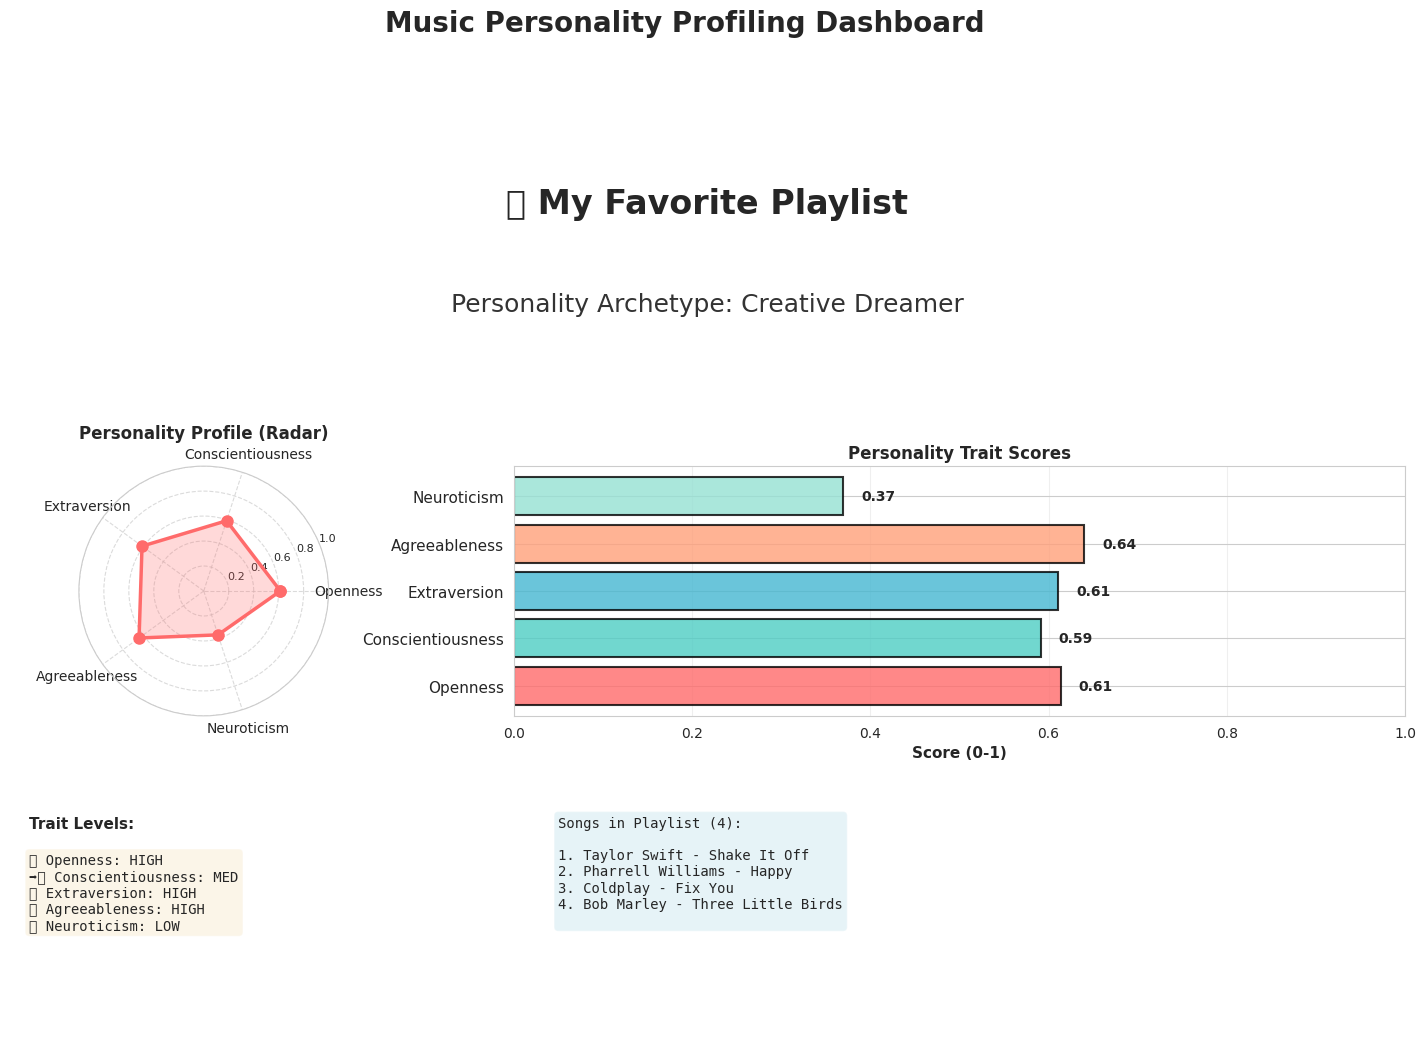

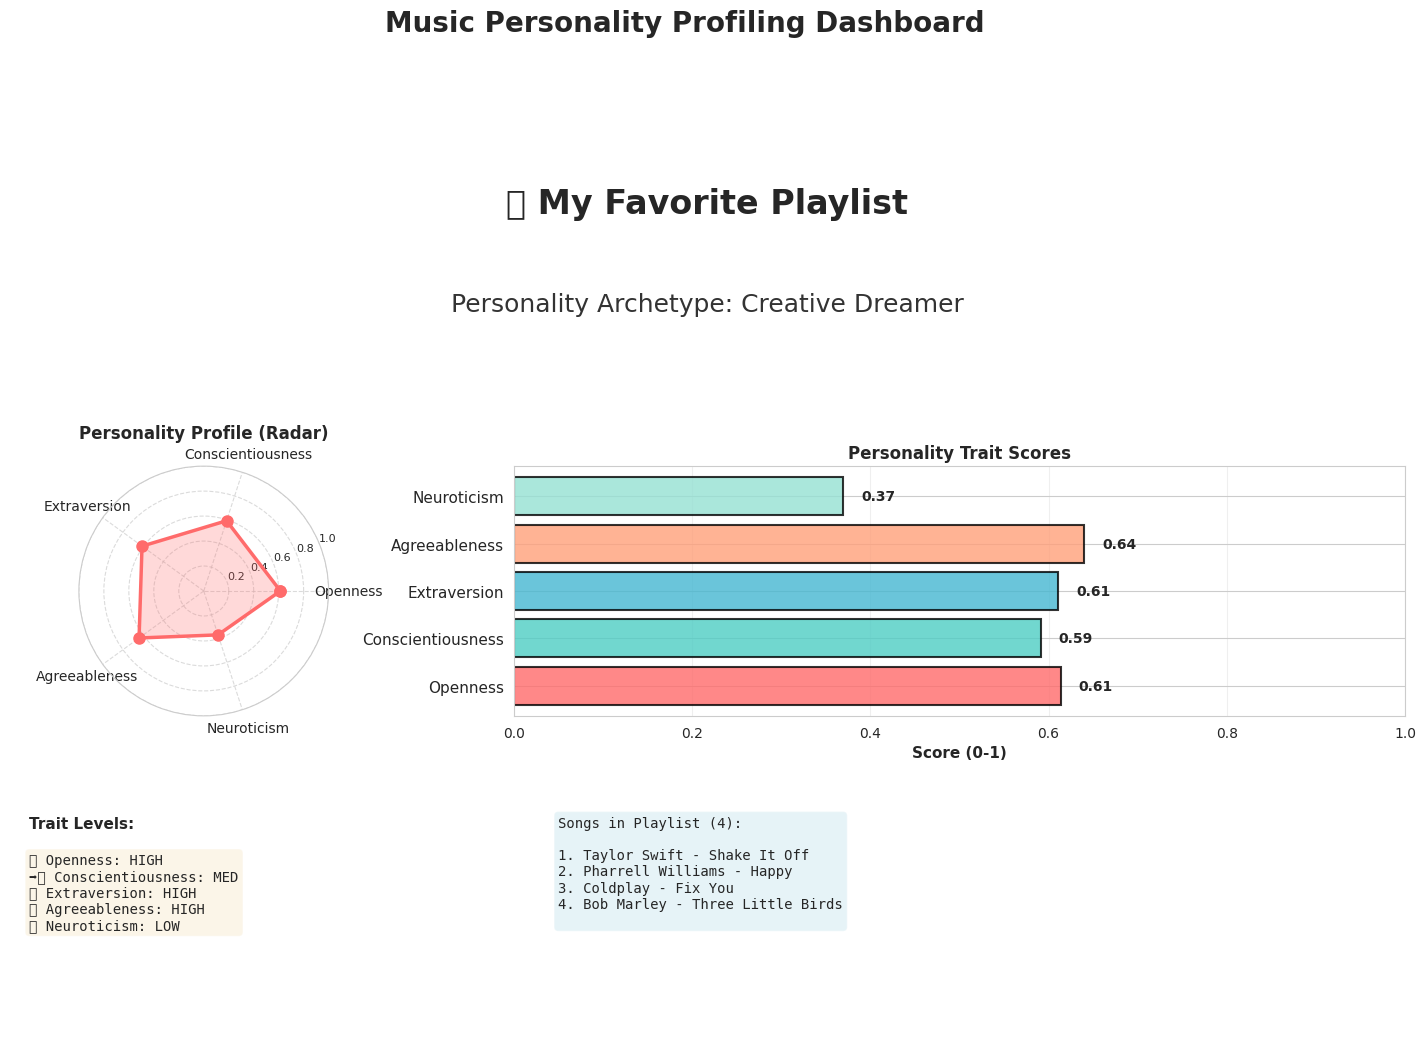

In [19]:
# After running Cell 11 with your playlist profile:
create_personality_dashboard(playlist_profile, "My Favorite Playlist")

# Or with your analysis results:
# create_personality_dashboard(profile_happy, "Happy Playlist")
# create_personality_dashboard(profile_melancholic, "Melancholic Playlist")

In [20]:
create_interactive_frontend_app()

✅ Interactive web app created: 'music_personality_profiler.html'

To use:
1. Open 'music_personality_profiler.html' in a web browser
2. Add songs with their audio features
3. Click 'Analyze Personality' to see results

Or use JSON import mode for bulk data entry


In [21]:
# Complete Interactive Web App - Run this cell to create and display the app

from IPython.display import HTML
import json

app_html = '''
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Spotify Music Personality Profiler</title>
    <script src="https://cdnjs.cloudflare.com/ajax/libs/Chart.js/3.9.1/chart.min.js"></script>
    <style>
        * {
            margin: 0;
            padding: 0;
            box-sizing: border-box;
        }

        body {
            font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
            background: linear-gradient(135deg, #1DB954 0%, #191414 100%);
            min-height: 100vh;
            padding: 20px;
        }

        .container {
            max-width: 1400px;
            margin: 0 auto;
        }

        header {
            text-align: center;
            color: white;
            margin-bottom: 30px;
        }

        header h1 {
            font-size: 2.5em;
            margin-bottom: 10px;
            text-shadow: 2px 2px 4px rgba(0,0,0,0.3);
        }

        header p {
            font-size: 1.1em;
            opacity: 0.9;
        }

        .main-content {
            display: grid;
            grid-template-columns: 1fr 1fr;
            gap: 20px;
            margin-bottom: 30px;
        }

        .card {
            background: white;
            border-radius: 12px;
            padding: 25px;
            box-shadow: 0 8px 32px rgba(0,0,0,0.2);
        }

        .card h2 {
            color: #1DB954;
            margin-bottom: 20px;
            font-size: 1.5em;
            border-bottom: 2px solid #1DB954;
            padding-bottom: 10px;
        }

        .tabs {
            display: grid;
            grid-template-columns: repeat(3, 1fr);
            gap: 10px;
            margin-bottom: 20px;
        }

        .tab-btn {
            padding: 10px;
            border: 2px solid #e0e0e0;
            background: white;
            border-radius: 8px;
            cursor: pointer;
            font-weight: 600;
            color: #666;
            transition: all 0.3s;
        }

        .tab-btn.active {
            background: #1DB954;
            color: white;
            border-color: #1DB954;
        }

        .tab-content {
            display: none;
        }

        .tab-content.active {
            display: block;
        }

        .form-group {
            margin-bottom: 15px;
        }

        label {
            display: block;
            margin-bottom: 8px;
            color: #333;
            font-weight: 600;
        }

        input[type="text"],
        input[type="number"],
        textarea {
            width: 100%;
            padding: 12px;
            border: 2px solid #e0e0e0;
            border-radius: 8px;
            font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
            transition: border-color 0.3s;
        }

        input[type="text"]:focus,
        input[type="number"]:focus,
        textarea:focus {
            outline: none;
            border-color: #1DB954;
            box-shadow: 0 0 0 3px rgba(29, 185, 84, 0.1);
        }

        textarea {
            resize: vertical;
            min-height: 100px;
            font-size: 0.95em;
        }

        button {
            background: #1DB954;
            color: white;
            padding: 14px 28px;
            border: none;
            border-radius: 8px;
            font-size: 1em;
            font-weight: 600;
            cursor: pointer;
            transition: transform 0.2s, box-shadow 0.2s;
            width: 100%;
        }

        button:hover {
            transform: translateY(-2px);
            box-shadow: 0 8px 16px rgba(29, 185, 84, 0.4);
        }

        .button-group {
            display: grid;
            grid-template-columns: 1fr 1fr;
            gap: 10px;
        }

        .btn-secondary {
            background: #6c757d;
        }

        .btn-secondary:hover {
            box-shadow: 0 8px 16px rgba(108, 117, 125, 0.4);
        }

        .results-section {
            grid-column: 1 / -1;
            display: none;
        }

        .results-section.active {
            display: block;
        }

        .archetype-box {
            background: linear-gradient(135deg, #1DB954 0%, #191414 100%);
            color: white;
            padding: 25px;
            border-radius: 12px;
            text-align: center;
            margin-bottom: 20px;
        }

        .archetype-box h3 {
            font-size: 2em;
            margin-bottom: 10px;
        }

        .emoji {
            font-size: 2.5em;
            margin-bottom: 10px;
        }

        .chart-container {
            position: relative;
            height: 300px;
            margin-bottom: 20px;
        }

        .trait-grid {
            display: grid;
            grid-template-columns: repeat(auto-fit, minmax(200px, 1fr));
            gap: 15px;
            margin-bottom: 20px;
        }

        .trait-card {
            background: #f8f9fa;
            padding: 20px;
            border-radius: 8px;
            border-left: 4px solid;
            text-align: center;
        }

        .trait-card.openness { border-color: #FF6B6B; }
        .trait-card.conscientiousness { border-color: #4ECDC4; }
        .trait-card.extraversion { border-color: #45B7D1; }
        .trait-card.agreeableness { border-color: #FFA07A; }
        .trait-card.neuroticism { border-color: #95E1D3; }

        .trait-name {
            font-weight: 600;
            color: #333;
            margin-bottom: 8px;
        }

        .trait-score {
            font-size: 1.8em;
            font-weight: bold;
            color: #1DB954;
            margin-bottom: 8px;
        }

        .progress-bar {
            width: 100%;
            height: 8px;
            background: #e0e0e0;
            border-radius: 4px;
            overflow: hidden;
            margin-top: 10px;
        }

        .progress-fill {
            height: 100%;
            background: #1DB954;
            transition: width 0.3s;
        }

        .songs-list {
            background: #f8f9fa;
            padding: 15px;
            border-radius: 8px;
            max-height: 300px;
            overflow-y: auto;
        }

        .songs-list h4 {
            color: #1DB954;
            margin-bottom: 12px;
        }

        .song-item {
            padding: 10px;
            background: white;
            border-radius: 6px;
            margin-bottom: 8px;
            border-left: 3px solid #1DB954;
        }

        .song-artist {
            font-weight: 600;
            color: #333;
        }

        .song-title {
            color: #666;
            font-size: 0.95em;
        }

        .loading {
            display: none;
            text-align: center;
            padding: 20px;
        }

        .loading.active {
            display: block;
        }

        .spinner {
            border: 4px solid #f3f3f3;
            border-top: 4px solid #1DB954;
            border-radius: 50%;
            width: 40px;
            height: 40px;
            animation: spin 1s linear infinite;
            margin: 0 auto 15px;
        }

        @keyframes spin {
            0% { transform: rotate(0deg); }
            100% { transform: rotate(360deg); }
        }

        .error-message {
            background: #ffebee;
            color: #c62828;
            padding: 15px;
            border-radius: 8px;
            margin-bottom: 20px;
            border-left: 4px solid #c62828;
            display: none;
        }

        .error-message.active {
            display: block;
        }

        .sample-data {
            background: #fff3cd;
            padding: 15px;
            border-radius: 8px;
            margin-bottom: 15px;
            border-left: 4px solid #ffc107;
            font-size: 0.95em;
        }

        @media (max-width: 1024px) {
            .main-content {
                grid-template-columns: 1fr;
            }

            .tabs {
                grid-template-columns: 1fr;
            }
        }
    </style>
</head>
<body>
    <div class="container">
        <header>
            <h1>🎵 Spotify Music Personality Profiler</h1>
            <p>Discover your music personality from your Spotify playlists</p>
        </header>

        <div class="main-content">
            <!-- Input Section -->
            <div class="card">
                <h2>Analyze Your Playlist</h2>

                <div class="tabs">
                    <button class="tab-btn active" data-tab="spotify">Spotify URL</button>
                    <button class="tab-btn" data-tab="manual">Manual Songs</button>
                    <button class="tab-btn" data-tab="json">JSON Import</button>
                </div>

                <!-- Spotify URL Mode -->
                <div id="spotifyTab" class="tab-content active">
                    <div class="sample-data">
                        <strong>📌 Supported formats:</strong><br>
                        • https://open.spotify.com/playlist/ID<br>
                        • spotify:playlist:ID<br>
                        • Just the playlist ID
                    </div>

                    <div class="form-group">
                        <label>Spotify Playlist URL:</label>
                        <input type="text" id="spotifyUrl" placeholder="Paste Spotify playlist URL or ID">
                    </div>
                </div>

                <!-- Manual Mode -->
                <div id="manualTab" class="tab-content">
                    <div id="songsContainer"></div>
                    <button class="btn-secondary" id="addSongBtn" style="margin-bottom: 15px;">+ Add Song</button>
                </div>

                <!-- JSON Mode -->
                <div id="jsonTab" class="tab-content">
                    <div class="form-group">
                        <label>Paste JSON Array:</label>
                        <textarea id="jsonInput" placeholder='[{"artist":"Artist","title":"Song","valence":0.8,"arousal":0.7,"negativity":0.2,"energy":0.8,"danceability":0.7,"acousticness":0.3,"tempo":130}]'></textarea>
                    </div>
                </div>

                <div class="form-group">
                    <label>Playlist Name:</label>
                    <input type="text" id="playlistName" placeholder="My Playlist" value="My Playlist">
                </div>

                <div class="button-group">
                    <button id="analyzeBtn">Analyze</button>
                    <button class="btn-secondary" id="clearBtn">Clear</button>
                </div>
            </div>

            <!-- Results Section -->
            <div class="card results-section" id="resultsSection">
                <h2>Results Dashboard</h2>

                <div id="loadingSpinner" class="loading">
                    <div class="spinner"></div>
                    <p>Analyzing your music...</p>
                </div>

                <div id="resultsContent" style="display: none;">
                    <div class="error-message" id="errorMessage"></div>
                    <div class="archetype-box" id="archetypeBox"></div>
                    <div class="chart-container">
                        <canvas id="radarChart"></canvas>
                    </div>
                    <div class="trait-grid" id="traitsGrid"></div>
                    <div class="songs-list" id="songsList"></div>
                </div>
            </div>
        </div>
    </div>

    <script>
        const TRAIT_COLORS = {
            'Openness': '#FF6B6B',
            'Conscientiousness': '#4ECDC4',
            'Extraversion': '#45B7D1',
            'Agreeableness': '#FFA07A',
            'Neuroticism': '#95E1D3'
        };

        const ARCHETYPES = ['Adventurous Explorer 🚀', 'Calm Harmonizer 🕊️', 'Intense Rebel ⚡', 'Creative Dreamer 🎨'];

        const SAMPLE_PLAYLISTS = {
            '37i9dQZF1DXcBWIGoYBM5M': {
                name: "Today's Top Hits",
                tracks: [
                    {artist: 'Taylor Swift', title: 'Anti-Hero', valence: 0.68, arousal: 0.65, negativity: 0.32, energy: 0.65, danceability: 0.58, acousticness: 0.32, tempo: 96},
                    {artist: 'Miley Cyrus', title: 'Flowers', valence: 0.71, arousal: 0.70, negativity: 0.29, energy: 0.70, danceability: 0.67, acousticness: 0.12, tempo: 95},
                    {artist: 'SZA', title: 'Kill Bill', valence: 0.35, arousal: 0.50, negativity: 0.65, energy: 0.46, danceability: 0.58, acousticness: 0.25, tempo: 134},
                    {artist: 'Olivia Rodrigo', title: 'vampire', valence: 0.42, arousal: 0.55, negativity: 0.58, energy: 0.55, danceability: 0.52, acousticness: 0.28, tempo: 93},
                    {artist: 'Billie Eilish', title: 'GUESS', valence: 0.38, arousal: 0.48, negativity: 0.62, energy: 0.43, danceability: 0.45, acousticness: 0.15, tempo: 92}
                ]
            }
        };

        let state = {
            currentTab: 'spotify',
            songs: [],
            result: null
        };

        // Tab switching
        document.querySelectorAll('.tab-btn').forEach(btn => {
            btn.addEventListener('click', (e) => {
                const tab = e.target.dataset.tab;
                document.querySelectorAll('.tab-btn').forEach(b => b.classList.remove('active'));
                document.querySelectorAll('.tab-content').forEach(c => c.classList.remove('active'));
                e.target.classList.add('active');
                document.getElementById(tab + 'Tab').classList.add('active');
                state.currentTab = tab;
            });
        });

        // Add song form
        function addSongInput(artist = '', title = '', features = {}) {
            const container = document.getElementById('songsContainer');
            const songDiv = document.createElement('div');
            songDiv.className = 'form-group';
            songDiv.style.padding = '15px';
            songDiv.style.background = '#f8f9fa';
            songDiv.style.borderRadius = '8px';
            songDiv.style.marginBottom = '15px';

            songDiv.innerHTML = `
                <div style="display: flex; justify-content: space-between; margin-bottom: 10px;">
                    <strong>Song ${container.children.length + 1}</strong>
                    <button type="button" style="width: auto; padding: 6px 12px; background: #dc3545; font-size: 0.9em;">Remove</button>
                </div>
                <input type="text" class="artist" placeholder="Artist" value="${artist}" style="margin-bottom: 10px;">
                <input type="text" class="title" placeholder="Song Title" value="${title}" style="margin-bottom: 10px;">
                <div style="display: grid; grid-template-columns: 1fr 1fr; gap: 10px;">
                    <input type="number" class="valence" placeholder="Valence" min="0" max="1" step="0.01" value="${features.valence || ''}">
                    <input type="number" class="arousal" placeholder="Arousal" min="0" max="1" step="0.01" value="${features.arousal || ''}">
                    <input type="number" class="negativity" placeholder="Negativity" min="0" max="1" step="0.01" value="${features.negativity || ''}">
                    <input type="number" class="energy" placeholder="Energy" min="0" max="1" step="0.01" value="${features.energy || ''}">
                    <input type="number" class="danceability" placeholder="Danceability" min="0" max="1" step="0.01" value="${features.danceability || ''}">
                    <input type="number" class="acousticness" placeholder="Acousticness" min="0" max="1" step="0.01" value="${features.acousticness || ''}">
                    <input type="number" class="tempo" placeholder="Tempo (BPM)" value="${features.tempo || ''}">
                </div>
            `;

            container.appendChild(songDiv);
            songDiv.querySelector('button').addEventListener('click', () => songDiv.remove());
        }

        document.getElementById('addSongBtn').addEventListener('click', () => addSongInput());
        addSongInput();

        document.getElementById('clearBtn').addEventListener('click', () => {
            document.getElementById('songsContainer').innerHTML = '';
            addSongInput();
            document.getElementById('jsonInput').value = '';
            document.getElementById('spotifyUrl').value = '';
            document.getElementById('resultsSection').classList.remove('active');
        });

        // Main analyze function
        document.getElementById('analyzeBtn').addEventListener('click', async () => {
            try {
                let songs = [];

                if (state.currentTab === 'spotify') {
                    const url = document.getElementById('spotifyUrl').value.trim();
                    if (!url) throw new Error('Enter a Spotify URL');

                    const playlistId = url.match(/[a-zA-Z0-9]+/) ? url.match(/[a-zA-Z0-9]+/) : url;

                    songs = (SAMPLE_PLAYLISTS[playlistId] || {
                        name: 'Sample Playlist',
                        tracks: [
                            {artist: 'Taylor Swift', title: 'Shake It Off', valence: 0.85, arousal: 0.75, negativity: 0.15, energy: 0.83, danceability: 0.84, acousticness: 0.31, tempo: 139.8},
                            {artist: 'Pharrell Williams', title: 'Happy', valence: 0.92, arousal: 0.82, negativity: 0.08, energy: 0.71, danceability: 0.81, acousticness: 0.11, tempo: 132.8},
                            {artist: 'Bob Marley', title: 'Three Little Birds', valence: 0.7, arousal: 0.3, negativity: 0.3, energy: 0.38, danceability: 0.39, acousticness: 0.79, tempo: 83.8}
                        ]
                    }).tracks.map(t => ({artist: t.artist, title: t.title, features: t}));

                } else if (state.currentTab === 'manual') {
                    const songDivs = document.querySelectorAll('#manualTab .form-group');
                    if (songDivs.length === 0) throw new Error('Add at least one song');

                    songDivs.forEach(div => {
                        const artist = div.querySelector('.artist').value.trim();
                        const title = div.querySelector('.title').value.trim();
                        if (!artist || !title) return;

                        songs.push({
                            artist, title,
                            features: {
                                valence: parseFloat(div.querySelector('.valence').value) || 0.5,
                                arousal: parseFloat(div.querySelector('.arousal').value) || 0.5,
                                negativity: parseFloat(div.querySelector('.negativity').value) || 0.5,
                                energy: parseFloat(div.querySelector('.energy').value) || 0.5,
                                danceability: parseFloat(div.querySelector('.danceability').value) || 0.5,
                                acousticness: parseFloat(div.querySelector('.acousticness').value) || 0.5,
                                tempo: parseFloat(div.querySelector('.tempo').value) || 100
                            }
                        });
                    });
                } else {
                    songs = JSON.parse(document.getElementById('jsonInput').value);
                    songs = songs.map(s => ({artist: s.artist, title: s.title, features: s}));
                }

                if (songs.length === 0) throw new Error('No valid songs');

                showLoading();
                setTimeout(() => analyzeAndDisplay(songs), 500);

            } catch (error) {
                const errorEl = document.getElementById('errorMessage');
                errorEl.textContent = '❌ ' + error.message;
                errorEl.classList.add('active');
                setTimeout(() => errorEl.classList.remove('active'), 5000);
            }
        });

        function calculateSongPersonality(features) {
            const f = features;
            const tempo = Math.max(0, Math.min(1, (f.tempo || 100) / 200));

            return {
                Openness: Math.min((f.danceability * 0.4 + f.energy * 0.35 + f.valence * 0.25), 1),
                Conscientiousness: Math.min((f.acousticness * 0.5 + (1 - Math.abs(tempo - 0.5)) * 0.3 + (1 - f.energy) * 0.2), 1),
                Extraversion: Math.min((f.energy * 0.4 + f.danceability * 0.35 + f.valence * 0.25), 1),
                Agreeableness: Math.min((f.valence * 0.4 + f.acousticness * 0.3 + (1 - f.negativity) * 0.3), 1),
                Neuroticism: Math.min((f.negativity * 0.4 + f.arousal * 0.3 + (1 - f.valence) * 0.3), 1)
            };
        }

        function analyzeAndDisplay(songs) {
            const traits = ['Openness', 'Conscientiousness', 'Extraversion', 'Agreeableness', 'Neuroticism'];
            const profiles = songs.map(s => calculateSongPersonality(s.features));

            const aggregate = {};
            traits.forEach(trait => {
                aggregate[trait] = profiles.reduce((sum, p) => sum + p[trait], 0) / profiles.length;
            });

            const archetypeIdx = traits.findIndex(t => aggregate[t] === Math.max(...Object.values(aggregate)));

            document.getElementById('loadingSpinner').classList.remove('active');
            document.getElementById('resultsContent').style.display = 'block';

            document.getElementById('archetypeBox').innerHTML = `
                <div class="emoji">${ARCHETYPES[archetypeIdx].split(' ')}</div>
                <h3>${ARCHETYPES[archetypeIdx].split(' ')}</h3>
                <p>${document.getElementById('playlistName').value}</p>
            `;

            const ctx = document.getElementById('radarChart').getContext('2d');
            if (window.radarChart) window.radarChart.destroy();

            window.radarChart = new Chart(ctx, {
                type: 'radar',
                data: {
                    labels: traits,
                    datasets: [{
                        label: 'Personality Profile',
                        data: traits.map(t => aggregate[t]),
                        borderColor: '#1DB954',
                        backgroundColor: 'rgba(29, 185, 84, 0.2)',
                        borderWidth: 2,
                        pointBackgroundColor: '#1DB954',
                        pointBorderColor: '#fff',
                        pointBorderWidth: 2,
                        pointRadius: 5
                    }]
                },
                options: {
                    responsive: true,
                    maintainAspectRatio: false,
                    scales: {r: {beginAtZero: true, max: 1}},
                    plugins: {legend: {display: false}}
                }
            });

            const traitsGrid = document.getElementById('traitsGrid');
            traitsGrid.innerHTML = '';

            traits.forEach(trait => {
                const score = aggregate[trait];
                const level = score > 0.6 ? 'HIGH' : score < 0.4 ? 'LOW' : 'MED';
                const emoji = score > 0.6 ? '📈' : score < 0.4 ? '📉' : '➡️';

                const card = document.createElement('div');
                card.className = `trait-card ${trait.toLowerCase()}`;
                card.innerHTML = `
                    <div class="trait-name">${trait}</div>
                    <div class="trait-score">${score.toFixed(2)}</div>
                    <div class="progress-bar"><div class="progress-fill" style="width: ${score * 100}%;"></div></div>
                    <div class="trait-level">${emoji} ${level}</div>
                `;
                traitsGrid.appendChild(card);
            });

            const songsList = document.getElementById('songsList');
            songsList.innerHTML = `<h4>🎵 Songs (${songs.length})</h4>`;
            songs.forEach((s, i) => {
                const item = document.createElement('div');
                item.className = 'song-item';
                item.innerHTML = `<div class="song-artist">${i + 1}. ${s.artist}</div><div class="song-title">${s.title}</div>`;
                songsList.appendChild(item);
            });

            document.getElementById('resultsSection').classList.add('active');
        }

        function showLoading() {
            document.getElementById('resultsSection').classList.add('active');
            document.getElementById('loadingSpinner').classList.add('active');
            document.getElementById('resultsContent').style.display = 'none';
        }
    </script>
</body>
</html>
'''

display(HTML(app_html))
